## Implementation of a simple Actor-Critic algorithm
### Using Cartpole environment provided by gym

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
# neural network
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        # critic layers
        torch.manual_seed(1)
        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        #actor layers
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        torch.manual_seed(1)
        state = Variable(torch.from_numpy(state).float().unsqueeze(0)) # state to tensor
        value = F.relu(self.critic_linear1(state)) # go through first layer
        value = self.critic_linear2(value) # go through last layer
        
        policy_dist = F.relu(self.actor_linear1(state)) # go through first layer
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1) # go through last layer, and turn into probabilities

        return value, policy_dist # return value (given state) & action prob_dist (given state)

In [33]:
def take_steps(actor_critic, env, max_steps, entropy_term): 
    num_outputs = env.action_space.n
    action_space = np.arange(env.action_space.n)
    done = False
    state = env.reset()
    states, rewards, logprobs, values = [], [], [], []
    
    for step in range(max_steps):
        value, policy_dist = actor_critic.forward(state)
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = env.step(action)
        
        states.append(state)
        rewards.append(reward)
        values.append(value)
        logprobs.append(log_prob)
        entropy_term += entropy
        state = new_state
        
        if done or step == max_steps-1:
            #save only the last next_value
            next_value, _ = actor_critic.forward(new_state)
            next_value = next_value.detach().numpy()[0,0]
            break # breaks if episode ended or max number of steps is achieved
                  #(can also chose to continue but need to save several next values then)

    
    return states, rewards, logprobs, values, next_value, entropy_term

In [39]:
def get_Qvals(Qvals, rewards, gamma, next_value):
    for t in reversed(range(len(rewards))):
        next_value = rewards[t] + gamma * next_value
        Qvals[t] = next_value
    return Qvals

In [49]:
def test_net(actor_critic, env, count=10):
    rewards = 0.0
    action_space = np.arange(env.action_space.n)
    for _ in range(count): # test for count episodes
        state = env.reset()
        while True:
            _, policy_dist = actor_critic.forward(state)
            dist = policy_dist.detach().numpy() 
            action = np.random.choice(action_space, p=np.squeeze(dist))
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                break
    return rewards / count # return average reward of the episodes

In [58]:
def a2c(env, hidden_size, learning_rate, gamma, max_steps, total_steps):
    all_rewards = []
    test_returns = []
    
    #initialize model and optimizer
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size) # can call predict(state)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
    
    #define others
    action_space = np.arange(env.action_space.n)
    entropy_term = 0 

    for idx in range(total_steps):
        #get some steps
        states, rewards, logprobs, values, next_value, entropy_term = take_steps(actor_critic, env, max_steps, entropy_term)
        
        #save and print progress
        all_rewards.append(sum(rewards))
        if idx % 10 == 0:
            test = test_net(actor_critic, env, 10)
            test_returns.append(test)
            print("step: ", idx," return: ", test)
            
        Qvals = np.zeros_like(values)
        Q = get_Qvals(Qvals, rewards, gamma, next_value)
        
        # convert to tensors
        values = torch.FloatTensor(values)
        Q = torch.FloatTensor(Q)
        logprobs = torch.stack(logprobs)
        
        #calculate Advantage
        A = Q - values
        
        #calculate loss for actor-critic
        actor_loss = (-logprobs * A).mean()
        critic_loss = 0.5 * A.pow(2).mean() # MSE
        ac_loss = (actor_loss + critic_loss) - 0.01 * entropy_term
        
        #update actor-critic parameters
        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()  
    
    
    return all_rewards, test_returns

step:  0  return:  23.3
step:  10  return:  19.1
step:  20  return:  23.1
step:  30  return:  25.4
step:  40  return:  28.3
step:  50  return:  28.2
step:  60  return:  30.9
step:  70  return:  31.4
step:  80  return:  24.1
step:  90  return:  29.4
step:  100  return:  28.0
step:  110  return:  28.0
step:  120  return:  27.9
step:  130  return:  29.9
step:  140  return:  24.5
step:  150  return:  33.0
step:  160  return:  35.4
step:  170  return:  28.4
step:  180  return:  42.4
step:  190  return:  32.5
step:  200  return:  32.3
step:  210  return:  41.1
step:  220  return:  32.4
step:  230  return:  36.4
step:  240  return:  34.4
step:  250  return:  37.2
step:  260  return:  29.8
step:  270  return:  38.0
step:  280  return:  52.6
step:  290  return:  45.2
step:  300  return:  56.8
step:  310  return:  38.5
step:  320  return:  42.7
step:  330  return:  69.0
step:  340  return:  40.4
step:  350  return:  40.3
step:  360  return:  36.4
step:  370  return:  47.0
step:  380  return:  54

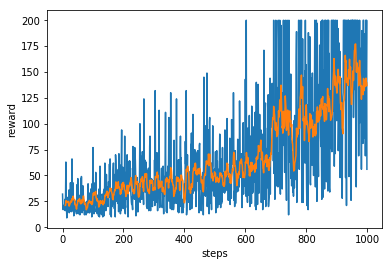

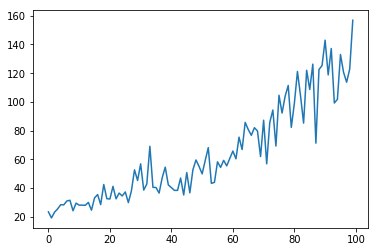

In [60]:
env = gym.make("CartPole-v0")
env.seed(0)
all_rewards, test_returns = a2c(env, hidden_size = 256, learning_rate = 3e-4, gamma = 0.99, max_steps = 200, total_steps = 1000)

smooth_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smooth_rewards = [elem for elem in smooth_rewards]

plt.plot(all_rewards)
plt.plot(smooth_rewards)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()

plt.plot(test_returns)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()

step:  0  return:  20.0
step:  10  return:  21.6
step:  20  return:  20.3
step:  30  return:  25.0
step:  40  return:  22.1
step:  50  return:  20.6
step:  60  return:  32.8
step:  70  return:  25.7
step:  80  return:  20.5
step:  90  return:  20.8
step:  100  return:  22.2
step:  110  return:  24.9
step:  120  return:  23.6
step:  130  return:  32.7
step:  140  return:  30.8
step:  150  return:  30.8
step:  160  return:  19.1
step:  170  return:  27.1
step:  180  return:  25.9
step:  190  return:  24.4
step:  200  return:  28.6
step:  210  return:  22.0
step:  220  return:  29.2
step:  230  return:  24.1
step:  240  return:  28.6
step:  250  return:  27.0
step:  260  return:  24.3
step:  270  return:  25.0
step:  280  return:  31.5
step:  290  return:  33.7
step:  300  return:  27.7
step:  310  return:  30.2
step:  320  return:  37.7
step:  330  return:  24.9
step:  340  return:  41.4
step:  350  return:  27.4
step:  360  return:  44.0
step:  370  return:  38.5
step:  380  return:  32

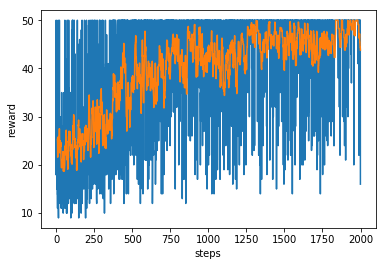

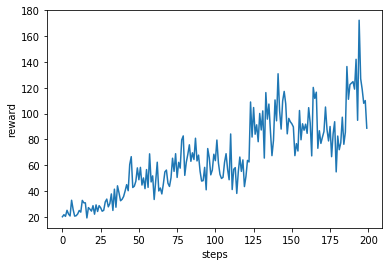

In [61]:
env = gym.make("CartPole-v0")
env.seed(0)
all_rewards, test_returns = a2c(env, hidden_size = 256, learning_rate = 3e-4, gamma = 0.99, max_steps = 50, total_steps = 2000)

smooth_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smooth_rewards = [elem for elem in smooth_rewards]

plt.plot(all_rewards)
plt.plot(smooth_rewards)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()

plt.plot(test_returns)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()

step:  0  return:  19.1
step:  10  return:  21.0
step:  20  return:  21.0
step:  30  return:  27.2
step:  40  return:  25.7
step:  50  return:  20.5
step:  60  return:  24.5
step:  70  return:  19.4
step:  80  return:  21.9
step:  90  return:  16.9
step:  100  return:  21.4
step:  110  return:  23.8
step:  120  return:  25.2
step:  130  return:  32.5
step:  140  return:  23.7
step:  150  return:  33.8
step:  160  return:  42.2
step:  170  return:  38.9
step:  180  return:  35.3
step:  190  return:  31.0
step:  200  return:  29.9
step:  210  return:  33.8
step:  220  return:  34.0
step:  230  return:  28.9
step:  240  return:  45.2
step:  250  return:  32.9
step:  260  return:  39.7
step:  270  return:  33.2
step:  280  return:  41.4
step:  290  return:  40.3
step:  300  return:  40.6
step:  310  return:  38.5
step:  320  return:  35.7
step:  330  return:  37.3
step:  340  return:  67.6
step:  350  return:  44.7
step:  360  return:  60.4
step:  370  return:  49.8
step:  380  return:  41

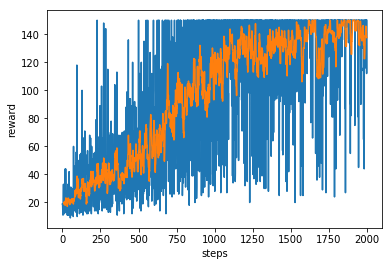

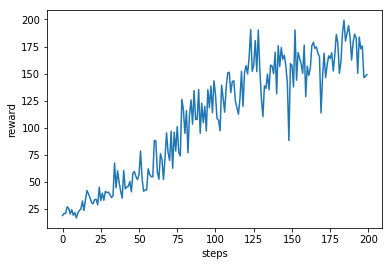

In [62]:
env = gym.make("CartPole-v0")
env.seed(0)
all_rewards, test_returns = a2c(env, hidden_size = 256, learning_rate = 3e-4, gamma = 0.99, max_steps = 150, total_steps = 2000)

smooth_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smooth_rewards = [elem for elem in smooth_rewards]

plt.plot(all_rewards)
plt.plot(smooth_rewards)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()

plt.plot(test_returns)
plt.ylabel("reward")
plt.xlabel("steps")
plt.show()